# Reptile訓練Omniglot資料集文字分類
[Reptile](https://arxiv.org/abs/1803.02999)是OpenAI開發的Optimization based meta learning演算法。
MAML演算法將meta model的更新建立於子任務"學習"的方向上，擷取每個子任務學習(gradient descent)一陣子後，接下來要學習的方向為meta model更新的方向。Reptile把這個過程簡化，變成將每個子任務學習最終模型與元模型差當作更新方向。

如下圖：模型$\Phi$的初始值是$\Phi_0$，學習task1時更新$gd_1$變成$\Phi_{11}$，再更新$gd_2$變成$\Phi_{12}$，最終使meta模型$\Phi$從$\Phi_0$更新到$\Phi_{R1}$。

接下來下個任務來了，從初始值$\Phi_{R1}$開始訓練，更新成$\Phi_{21}$然後$\Phi_{22}$，最終使meta模型$\Phi$從$\Phi_{R1}$更新到$\Phi_{R2}$。



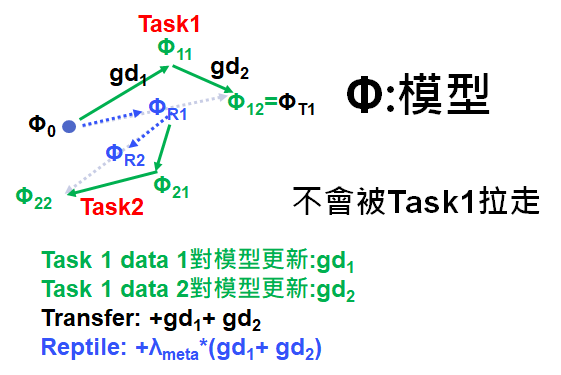

這次使用Reptile實作在Omniglot資料集上：
* source有3856個來自不同語言的不同字符，target有659個不同字符
* 每個class有20張不同人手寫的同一個文字的圖片
* 每個task的source是隨機抽3個字符，每個字符5張照片做訓練
* query是同樣3個字符裡面另外1張照片，需推論這張照片屬於三個字符裡面哪一個

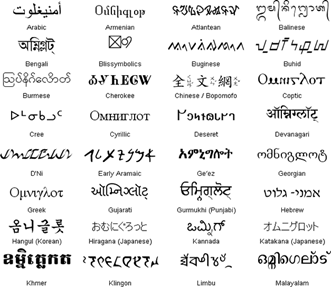

**程式碼部分會做以下部分：**
* Data Loader
* 建立模型
* 模型訓練+測試

# Data Loader
* (meta)batch: 一次訓練BATCH_SIZE個task
* task: Source- 3856字符選3字符不重複 Target-659字符選3字符不重複
* support: 3字符每字20張圖片選3張當support
* query: 3字符剩餘圖片中選一張當query

In [1]:
# Colab上的話要下載資料
# workspace_dir = '.'
# # download from GoogleDrive
# !gdown --id 1FLDrQ0k-iJ-mk8ors0WItqvwgu0w9J0U --output "{workspace_dir}/Omniglot.tar.gz" # download from google drive
# !tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"   # untar

ref:
* https://github.com/ShuYuHuang/kaggle_small_data/

In [2]:
import os
from glob import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Dense,Dropout,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization,ReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras import callbacks as cb
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
# 可以使用set_memory_growth避免tensorflow一次耗掉整顆GPU資源，要多少拿多少
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)

首先擷取Dataset所在資料夾，列出source跟target用到的classes資料夾

使用glob可以列出input文字的資料夾內容，其中\*代表任意字數的任意字

In [4]:
# from local
DATA_DIR='../datasets/Omniglot_splited'

# Colab上的話要下載資料
# workspace_dir = '.'
# # download from GoogleDrive
# !gdown --id 1FLDrQ0k-iJ-mk8ors0WItqvwgu0w9J0U --output "{workspace_dir}/Omniglot.tar.gz" # download from google drive
# !tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"   # untar
# DATA_DIR='./Omniglot'

source_classes=glob(os.path.join(DATA_DIR, 'images_background/*/*'))
target_classes=glob(os.path.join(DATA_DIR, 'images_evaluation/*/*'))
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {sorce_len+target_len} classes=source {sorce_len} + target {target_len} classes")

total 4515 classes=source 3856 + target 659 classes


製作讀取圖案並前處理的function

使用cv2.imread讀檔案時，因為後續我們會使用tf.data.Dataset.list_files來列舉檔案名稱變成tf tensor，所以使用.numpy.decode()將其解碼為文字

前處理會將圖片從0-255拉到0-1之間，然後取圖片中間長寬為min_of_shape的區塊，這個大小是元圖長、寬中較小的那個值。

最後RESIZE到W,H大小

因為這組圖都是黑白的，所以原本的png檔讀出來後我只要RGB中任一channel就好了

In [5]:
W,H,CH = 64,64,1

def load_img(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.png'

接著整理訓練用資料

因為當每個class資料數不平均，有可能有些class缺資料，如果class很多，也可以篩掉那些數量不夠多的class

In [6]:
WAYS=3
SHOTS=5
QUERIES=1

In [7]:
min([len(glob(os.path.join(sdir,'*.png'))) for sdir in source_classes])

20

In [8]:
## exclude classes with too few examples
source_classes=[sdir for sdir in source_classes if len(glob(sdir+'/*'+SUFFIX))>SHOTS+QUERIES]

sorce_len=len(source_classes)
print(f"source {sorce_len} + target {target_len} classes")

source 3856 + target 659 classes


In [9]:
min([len(glob(os.path.join(sdir,'*.png'))) for sdir in source_classes])

20

關鍵的Dataloader使用兩層tf.data.Dataset class來完成:
第一層random選取class，第二層random選取照片

實作上，第一層的loader會隨機去抽第二層的loader。

In [10]:
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
# 指定抽照片的loader，每個class各有一個tf.data.Dataset.list_files的loader
# 這邊要指定格式化不然會有bug, 會搜到多餘的暫存檔案
source_sub = [
  tf.data.Dataset.list_files(os.path.join(sc,'????_??.png'), shuffle=True)
  .map(map_fun)
  for sc in source_classes
]
target_sub = [
  tf.data.Dataset.list_files(os.path.join(sc,'????_??.png'), shuffle=True)
  .map(map_fun)
  for sc in target_classes
]

# 使用tf.data.Dataset.from_generator作class loader 的loader時需要呼叫一個函數
# 因此這邊組一個函數丟給它
def gen(all_sub):
    # 這個函數會丟進一個list的file loader，首先先permute一下順序，目的是希望打亂task進到model的順序
    order=np.random.permutation(len(all_sub))
    for tasks in range(len(all_sub)//WAYS):
        # 每次抽取WAYS個file loader，後面使用batch來抽數張照片
        # prefetch可以將資料先放進memory中WAYS個batch，下個batch要用就會比較快
        picked=[all_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        # Support
        support = tf.concat(
          [
            next(
              iter(
                  sub.batch(SHOTS).prefetch(WAYS)
              )
              ) for sub in picked
          ]
          , axis=0)
        # 這邊每個task的label都是自己取的，編號從0開始加到WAYS-1
        support_label=tf.repeat(tf.range(WAYS,dtype=tf.float32),SHOTS)
        # Shuffle support
        order2=np.random.permutation(WAYS*SHOTS)
        support=tf.stack([support[ii] for ii in order2])
        support_label=tf.stack([support_label[ii] for ii in order2])

        # Query
        query_label=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
          [
            next(
              iter(
                  picked[idx].batch(1).prefetch(1)
              )
              ) for idx in query_label
          ]
          , axis=0)
        yield (support,query),(support_label,query_label)

def gen_source():
    return gen(source_sub)
def gen_target():
    return gen(target_sub)

data_source = tf.data.Dataset.from_generator(gen_source,
                        output_types=((tf.float32,tf.float32),(tf.float32,tf.float32)),
                        output_shapes=(((WAYS*SHOTS,W,H,CH),(QUERIES,W,H,CH)),((WAYS*SHOTS,),(QUERIES,)))
                        )
data_target = tf.data.Dataset.from_generator(gen_target,
                        output_types=((tf.float32,tf.float32),(tf.float32,tf.float32)),
                        output_shapes=(((WAYS*SHOTS,W,H,CH),(QUERIES,W,H,CH)),((WAYS*SHOTS,),(QUERIES,)))
                        )

# 建立模型
* 這邊使用簡單的4層128單位的CNN，每層stride=2
* 每個specific task使用SGD做optimization
* Meta model使用Reptile方式更新

In [11]:
lr=0.003
# strategy = tf.distribute.MirroredStrategy()  
def conv_bn(x):
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding="valid")(x)
    x = BatchNormalization()(x)
    return ReLU()(x)

# with strategy.scope(): 
inputs = Input(shape=(64, 64, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = Flatten()(x)
outputs = Dense(WAYS, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.SGD(learning_rate=lr)
model.compile()
loss_fn=keras.losses.sparse_categorical_crossentropy

In [12]:
def acc_fn(label,pred):
    num_correct = (tf.argmax(pred,-1).numpy() ==label.numpy()).mean()
    return num_correct 

## 模型訓練+測試
* 總共抽出TOTAL_TASKS次
* 每BATCH_SIZE個TASK為一組，做meta rl修正，總共組數為meta_iters=TOTAL_TASKS//CYCLE_SIZE
* 每個task都有一組source set和一組query set，set中有數個image,label pairs
    1. 保留meta model parameter (old_vars)
    2. 在source set上一個task訓練ITERS次，知曉task specific model (new_vars)
    3. 訓練完透過query set驗證模型的loss, acc
    4. 以兩個模型差距作為距離更新meta model parameter

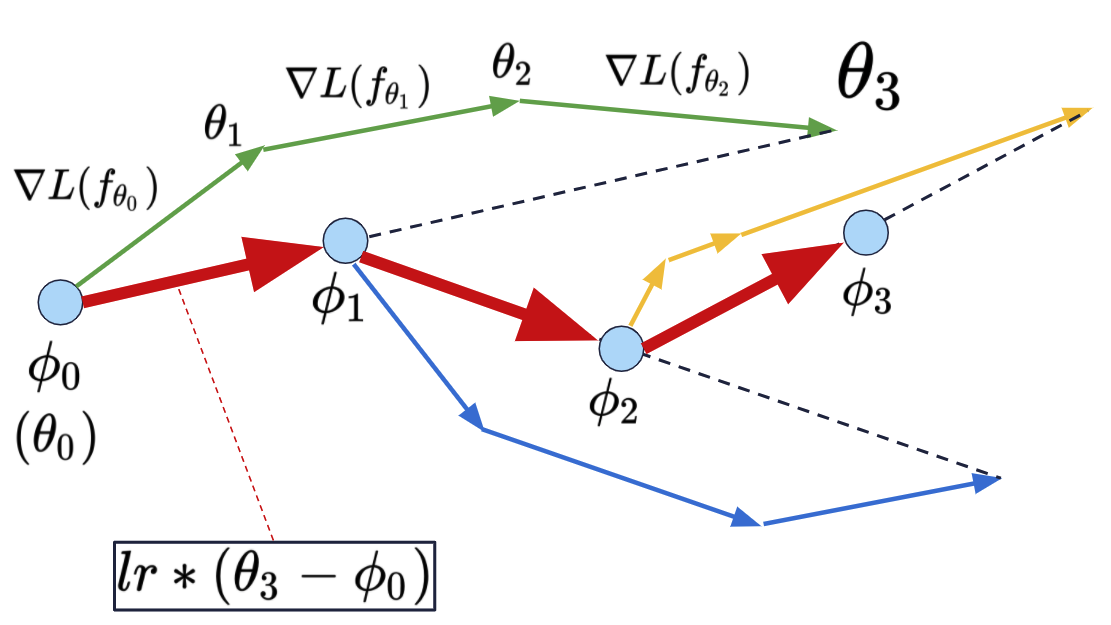

In [13]:
TOTAL_TASKS=2000
BATCH_SIZE=25
# BATCH_SIZE=len(source_sub)//WAYS
TASK_ITERS=4
meta_step_size = 0.25

for meta_iter in range(TOTAL_TASKS):
    # Update meta_lr
    frac_done = meta_iter / TOTAL_TASKS
    meta_lr = (1 - frac_done) * meta_step_size
    
    # Meta Training(Outer loop): 
    accuracies=list()
    losses=list()
    session=tqdm(data_source.batch(BATCH_SIZE))
    for (im_src_batch,im_q_batch),(label_src_batch,label_q_batch) in session:
        for images_src, image_q, labels_src, labels_q in zip(im_src_batch, im_q_batch, label_src_batch, label_q_batch):
            old_vars = model.get_weights()
            
            # Task Specific Training(Inner loop):
            for _ in range(TASK_ITERS):
                with tf.GradientTape() as tape:
                    preds = model(images_src)
                    loss= loss_fn(labels_src, preds)
                grads=tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

            ## Validate the task
            preds_q =model.predict(image_q) 
            losses.append(loss_fn(labels_q, preds_q).numpy())
            accuracies.append(acc_fn(labels_q,preds_q))
            session.set_postfix({"source query loss": np.stack(losses).mean(),"acc":np.stack(accuracies).mean()})

            ## Meta update: Perform SGD for the meta step.
            new_vars = model.get_weights()
            new_vars=[o_var+(n_var-o_var)*meta_lr for n_var,o_var in zip(new_vars,old_vars)]
            model.set_weights(new_vars)
    
    # Meta Testing(Outer loop): 
    test_acc=list()
    test_losses=list()
    session=tqdm(data_target.batch(5))
    for (im_src_batch, im_q_batch), (label_src_batch, label_q_batch) in session:
        for images_src, image_q, labels_src, labels_q in zip(im_src_batch, im_q_batch, label_src_batch, label_q_batch):
            old_vars = model.get_weights()
            
            # Task Specific Training(Inner loop):
            for _ in range(TASK_ITERS):
                with tf.GradientTape() as tape:
                    preds = model(images_src)
                    loss= loss_fn(labels_src, preds)
                grads=tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

            ## Validate the task
            preds_q =model.predict(image_q) 
            test_losses.append(loss_fn(labels_q, preds_q).numpy())
            test_acc.append(acc_fn(labels_q,preds_q))
            session.set_postfix({"target query loss": np.stack(test_losses).mean(),"acc":np.stack(test_acc).mean()})
            
            model.set_weights(old_vars)

52it [03:33,  4.11s/it, source query loss=0.603, acc=0.782]
44it [00:35,  1.23it/s, target query loss=0.441, acc=0.813]
30it [01:57,  3.91s/it, source query loss=0.447, acc=0.834]


KeyboardInterrupt: 

# Exercise
試著修改以下參數，觀察結果如何

1.   WAYS: 3->5, 
2.   SHOTS: 5->3
3.   QUERIES: 1->3 



# Reference
[Reptile](https://arxiv.org/abs/1803.02999)